In [1]:
import pandas as pd
from tqdm import tqdm
%matplotlib inline

In [123]:
dau=pd.read_csv("practice_dau_and.csv",sep="|",header=None,names=["id","country","number_of_pgr","actdate"],
               parse_dates=[3])
sessions=pd.read_csv("practice_sessions_and.csv",sep="|",header=None,names=
                     ["id","session_number","session_length","session_start_time","session_end_time","actdate"],
                    parse_dates=[5])

In [131]:
dau

,id,country,number_of_pgr,actdate
0,c7a56d9eee,FR,33,2017-01-01
1,bd4b8c265d,GB,47,2017-01-20
2,bd4b8c265d,GB,6,2017-01-27
3,bd4b8c265d,GB,11,2017-01-25
4,bd4b8c265d,GB,78,2017-02-05
5,bd4b8c265d,GB,11,2017-01-14
6,fc2996c189,US,15,2017-01-28
7,fbe11f7261,NL,34,2017-01-07
8,c379092cc7,KR,9,2017-01-13
9,6e103c0821,MY,7,2017-01-12


In [3]:
pact=pd.read_csv("practice_pact_and.csv",sep="|",header=None,names=
                 ["id","actdate","regdate","clusters_ml_ended","revenue","transactions","quests_end","m_quests_end",
                  "crystals_value_spend","store_enters"],parse_dates=[1,2])

In [4]:
pact=pd.merge(pact.groupby("id").regdate.min().to_frame(),pact.drop("regdate",axis=1),
                   left_index=True,right_on="id",sort=False).sort_index()

In [5]:
pact.head()

,regdate,id,actdate,clusters_ml_ended,revenue,transactions,quests_end,m_quests_end,crystals_value_spend,store_enters
0,2017-01-01,abee37a4e1,2017-01-01,7,0.0,0,61,13,0,0
1,2017-01-01,6fbbafd123,2017-01-01,5,0.0,0,73,14,0,0
2,2017-01-01,23c025efd0,2017-01-01,7,0.0,0,91,17,0,0
3,2017-01-01,8f4b043ead,2017-01-01,2,0.0,0,14,1,0,0
4,2017-01-01,1bdb89a697,2017-01-01,2,0.0,0,11,0,0,0


In [6]:
pact_regdates=pact.groupby("id").regdate.min().to_frame()

In [7]:
pact_regdates

,regdate
id,
00000294ec,2017-02-28
00001b9fac,2017-04-03
00002a568e,2017-03-11
000032d12a,2017-03-26
000038981a,2017-04-14
000042b6ca,2017-03-04
000046c683,2017-02-06
00004e6b44,2017-01-16
00004f0c69,2017-03-03


In [8]:
pact_3days=pact[(pact.actdate-pact.regdate)<=pd.Timedelta(days=2)]

In [9]:
pact_15days=pact[(pact.actdate-pact.regdate)<=pd.Timedelta(days=14)]

In [10]:
y=pact_15days.groupby("id").revenue.sum().to_frame()

In [11]:
pact_3days["day"]=(pact_3days["actdate"]-pact_3days["regdate"]).dt.days

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [12]:
pact_3days

,regdate,id,actdate,clusters_ml_ended,revenue,transactions,quests_end,m_quests_end,crystals_value_spend,store_enters,day
0,2017-01-01,abee37a4e1,2017-01-01,7,0.00,0,61,13,0,0,0
1,2017-01-01,6fbbafd123,2017-01-01,5,0.00,0,73,14,0,0,0
2,2017-01-01,23c025efd0,2017-01-01,7,0.00,0,91,17,0,0,0
3,2017-01-01,8f4b043ead,2017-01-01,2,0.00,0,14,1,0,0,0
4,2017-01-01,1bdb89a697,2017-01-01,2,0.00,0,11,0,0,0,0
5,2017-01-01,115616a963,2017-01-01,-2,0.00,0,0,0,0,0,0
6,2017-01-01,df20c9e698,2017-01-01,1,0.00,0,10,0,0,0,0
7,2017-01-01,4a2098b23f,2017-01-01,3,0.00,0,44,5,0,0,0
8,2017-01-01,af5301ba3d,2017-01-01,2,0.00,0,18,3,0,0,0
9,2017-01-01,70795a73e6,2017-01-01,-2,0.00,0,0,0,0,0,0


In [14]:
pact_3days=pact_3days.set_index(["id","day"]).reindex(pd.MultiIndex.from_product([pact_3days["id"].unique(), range(3)], names=["id", "day"]))
pact_3days.regdate.fillna(method="ffill",inplace=True)
pact_3days.head()

regdate    actdate  clusters_ml_ended  revenue  \
id         day                                                     
abee37a4e1 0   2017-01-01 2017-01-01                7.0     0.00   
           1   2017-01-01 2017-01-02                8.0     0.00   
           2   2017-01-01 2017-01-03                9.0     0.00   
6fbbafd123 0   2017-01-01 2017-01-01                5.0     0.00   
           1   2017-01-01 2017-01-02                8.0  6799.49   

                transactions  quests_end  m_quests_end  crystals_value_spend  \
id         day                                                                 
abee37a4e1 0             0.0        61.0          13.0                   0.0   
           1             0.0        40.0           6.0                   0.0   
           2             0.0        13.0           5.0                   0.0   
6fbbafd123 0             0.0        73.0          14.0                   0.0   
           1             1.0       112.0          24.0                   0.0   

                store_enters  
id         day                
abee37a4e1 0             0.0  
           1             0.0  
           2             0.0  
6fbbafd123 0             0.0  
           1             0.0

In [15]:
pact_3days.actdate=pact_3days.apply(lambda x:pd.Timedelta(days=x.name[1])+x.regdate, axis=1)
pact_3days.fillna(0,inplace=True)
pact_3days.head()

regdate    actdate  clusters_ml_ended  revenue  \
id         day                                                     
abee37a4e1 0   2017-01-01 2017-01-01                7.0     0.00   
           1   2017-01-01 2017-01-02                8.0     0.00   
           2   2017-01-01 2017-01-03                9.0     0.00   
6fbbafd123 0   2017-01-01 2017-01-01                5.0     0.00   
           1   2017-01-01 2017-01-02                8.0  6799.49   

                transactions  quests_end  m_quests_end  crystals_value_spend  \
id         day                                                                 
abee37a4e1 0             0.0        61.0          13.0                   0.0   
           1             0.0        40.0           6.0                   0.0   
           2             0.0        13.0           5.0                   0.0   
6fbbafd123 0             0.0        73.0          14.0                   0.0   
           1             1.0       112.0          24.0                   0.0   

                store_enters  
id         day                
abee37a4e1 0             0.0  
           1             0.0  
           2             0.0  
6fbbafd123 0             0.0  
           1             0.0

In [16]:
pact_3days["regmonth"]=pact_3days.regdate.dt.month
pact_3days["regday"]=pact_3days.regdate.dt.day
pact_3days["actmonth"]=pact_3days.actdate.dt.month
pact_3days["actday"]=pact_3days.actdate.dt.day
pact_3days=pact_3days.drop(["regdate","actdate"],axis=1).reset_index().pivot(index="id",columns="day").drop(
    [("regmonth",1),("regmonth",2),("regday",1),("regday",2)],axis=1)
pact_3days.head()

clusters_ml_ended           revenue           transactions       \
day                        0    1    2       0    1    2            0    1   
id                                                                           
00000294ec              -2.0  0.0  0.0     0.0  0.0  0.0          0.0  0.0   
00001b9fac               3.0  0.0  0.0     0.0  0.0  0.0          0.0  0.0   
00002a568e               0.0  0.0  0.0     0.0  0.0  0.0          0.0  0.0   
000032d12a               0.0  0.0  0.0     0.0  0.0  0.0          0.0  0.0   
000038981a              -2.0  0.0  0.0     0.0  0.0  0.0          0.0  0.0   

                quests_end ... store_enters      regmonth regday actmonth     \
day           2          0 ...            1    2        0      0        0  1   
id                         ...                                                 
00000294ec  0.0        0.0 ...          0.0  0.0        2     28        2  3   
00001b9fac  0.0       20.0 ...          0.0  0.0        4      3        4  4   
00002a568e  0.0        4.0 ...          0.0  0.0        3     11        3  3   
000032d12a  0.0        1.0 ...          0.0  0.0        3     26        3  3   
000038981a  0.0        0.0 ...          0.0  0.0        4     14        4  4   

              actday          
day         2      0   1   2  
id                            
00000294ec  3     28   1   2  
00001b9fac  4      3   4   5  
00002a568e  3     11  12  13  
000032d12a  3     26  27  28  
000038981a  4     14  15  16  

[5 rows x 29 columns]

In [17]:
pact_3days.columns=["".join(map(str,col)) for col in pact_3days.columns]
pact_3days.rename(columns={"regmonth0":"regmonth","regday0":"regday"},inplace=True)
pact_3days.index.name=None
pact_3days.head()

,clusters_ml_ended0,clusters_ml_ended1,clusters_ml_ended2,revenue0,revenue1,revenue2,transactions0,transactions1,transactions2,quests_end0,...,store_enters1,store_enters2,regmonth,regday,actmonth0,actmonth1,actmonth2,actday0,actday1,actday2
00000294ec,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2,28,2,3,3,28,1,2
00001b9fac,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,...,0.0,0.0,4,3,4,4,4,3,4,5
00002a568e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3,11,3,3,3,11,12,13
000032d12a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,3,26,3,3,3,26,27,28
000038981a,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4,14,4,4,4,14,15,16


In [18]:
from tpot import TPOTRegressor


In [23]:
tpregr=TPOTRegressor(max_time_mins=60,verbosity=3,n_jobs=1,config_dict='TPOT light')

20 operators have been imported by TPOT.


In [24]:
tpregr.fit(pact_3days.values,y.values.reshape(-1,))

_pre_test decorator: _generate: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False
_pre_test decorator: _generate: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.
_pre_test decorator: _generate: num_test=0 l2 was provided as affinity. Ward can only work with euclidean distances.
_pre_test decorator: _generate: num_test=0 X contains negative values.
_pre_test decorator: _generate: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.
_pre_test decorator: _generate: num_test=1 manhattan was provided as affinity. Ward can only work with euclidean distances.


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]

_pre_test decorator: _generate: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 85
_pre_test decorator: _generate: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False



TPOT closed prematurely. Will use the current best pipeline.


TPOTRegressor(config_dict={'sklearn.feature_selection.SelectPercentile': {'percentile': range(1, 100), 'score_func': {'sklearn.feature_selection.f_classif': None}}, 'sklearn.linear_model.ElasticNetCV': {'l1_ratio': array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
        0.45,  0.5 ,  0.55,  ...': {'min_samples_leaf': range(1, 21), 'min_samples_split': range(2, 21), 'max_depth': range(1, 11)}},
       crossover_rate=0.1, cv=5, disable_update_check=False,
       generations=1000000, max_eval_time_mins=5, max_time_mins=60,
       mutation_rate=0.9, n_jobs=1, offspring_size=100,
       population_size=100, random_state=None, scoring=None, subsample=1.0,
       verbosity=3, warm_start=False)

In [103]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import ElasticNet, LinearRegression
import numpy as np

In [121]:
regr=XGBRegressor(max_depth=5,n_estimators=1000)

In [122]:
def scorer(estimator,X,y):
    y_pred=estimator.predict(X)
    return (mean_squared_error(y,y_pred),r2_score(y,y_pred))

def rmsle(estimator,X,y): 
    return np.sqrt(np.mean(np.square(np.log1p(estimator.predict(X)) - np.log1p(y))))

print(np.mean(-cross_val_score(regr,pact_3days,y,scoring="neg_mean_absolute_error",cv=5)),
     np.mean(np.sqrt(-cross_val_score(regr,pact_3days,y,scoring="neg_mean_squared_error",cv=5))),
     np.mean(cross_val_score(regr,pact_3days,y,scoring="r2",cv=5)))

165.463993605 2428.54619236 0.493821768831


In [119]:
np.mean(-sc)

160.10721825915536

In [109]:
np.mean(np.sqrt(-sc))

2312.933789039078

In [112]:
np.mean(sc)

0.54238774632330056

In [66]:
quant_x=pact_3days[y.loc[pact_3days.index].revenue<y.revenue.quantile(0.99)]
quant_y=y[y.revenue<y.revenue.quantile(0.99)]

In [67]:
regr.fit(quant_x,quant_y)
pred=pd.concat([pd.DataFrame(regr.predict(quant_x)),quant_y.reset_index().drop("id",axis=1)],axis=1)

In [105]:
mean_absolute_error(quant_y.revenue,pred[0].values)

2.8879706985079441

In [104]:
rmsle(quant_y.revenue,pred[0].values)

0.87186727297628142

In [101]:
np.sqrt(mean_squared_error(quant_y.revenue,pred[0].values))

42.860486909362173

In [102]:
r2_score(quant_y.revenue,pred[0].values)

0.60422939668556241

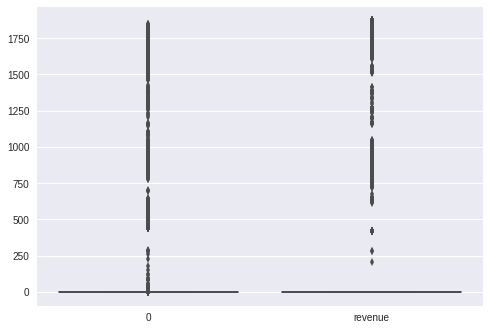

In [68]:
sns.boxplot(data=pred)